<a href="https://colab.research.google.com/github/ZYuliaA/Time-series/blob/main/%D0%94%D0%97_%D0%BA_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B8_2_%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.

Приблизьте оба варианта моделями из класса MA.

Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
air_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']
air_temp.head()

0    40.6
1    40.8
2    44.4
3    46.7
4    54.1
Name: Deg, dtype: float64

Text(0.5, 1.0, 'Mean monthly air temperature')

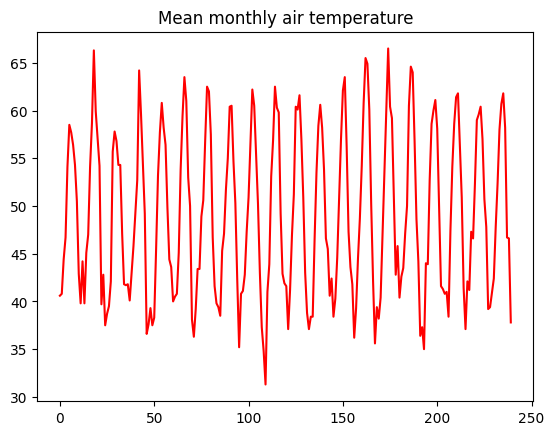

In [3]:
air_temp.plot(color='red')
plt.title('Mean monthly air temperature')

In [4]:
adf_test = adfuller(air_temp)
print('p-value = ' + str(adf_test[1]))

# стационарный ряд

p-value = 0.016989030222608604


In [5]:
def WMA(data, window, weights):
  weighted_ma = data.rolling(window).apply(lambda x: (x*weights).sum() / weights.sum()) 
  return weighted_ma

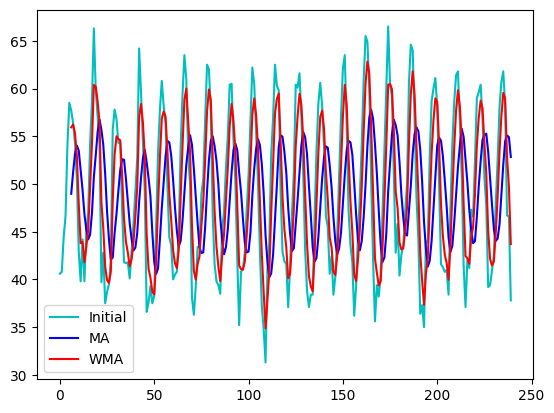

In [6]:
air_temp.plot(color='c', label='Initial')
air_temp.rolling(7).mean().plot(color='blue', label='MA')
WMA(pd.Series(air_temp), 7, np.array([1,2,4,8,16,32,64])).plot(color='red', label='WMA')
plt.legend()

# SMA уменьшила колебания
# WMA убрала запаздывание, больше внимания на последнее значение в окне, почти не сглаживает

In [7]:
def prediction(data, window, num_pred):
  new = air_temp.copy()
  for _ in range(num_pred):
    new = new.append(pd.Series([new[-window:].mean()]), ignore_index=True)
  return new

<ipython-input-7-31b1bae1aa73>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = new.append(pd.Series([new[-window:].mean()]), ignore_index=True)


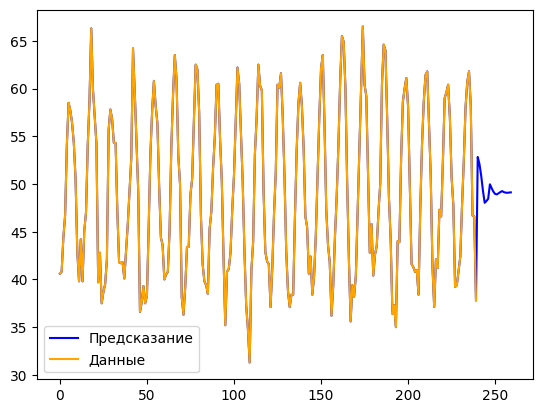

In [8]:
prediction(air_temp, 7, 20).plot(color='blue', label='Предсказание')
air_temp.plot(color='orange', label='Данные')
plt.legend()

In [9]:
train, test = air_temp[:200], air_temp[200:]

In [10]:
def rmse():
    result = WMA(pd.Series(train), 7, np.array([1,2,4,8,16,32,64]))
    predictions = result[-len(test):]
    error = np.sqrt(mean_squared_error(predictions, test))
    return error

print(f'Ошибка составляет: {round(rmse(), 2)}')

Ошибка составляет: 14.89


In [11]:
sales = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']
sales.head()

0    154
1     96
2     73
3     49
4     36
Name: Count, dtype: int64

Text(0.5, 1.0, 'Monthly sales of company')

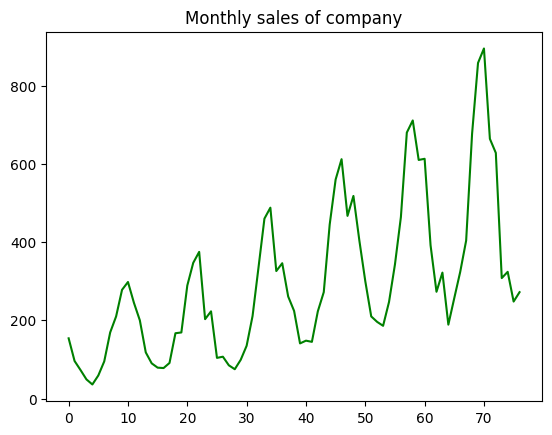

In [12]:
sales.plot(color='green')
plt.title('Monthly sales of company')

In [13]:
adf_test = adfuller(sales)
print('p-value = ' + str(adf_test[1]))

# ряд не стационарный 

p-value = 0.9888894205170052


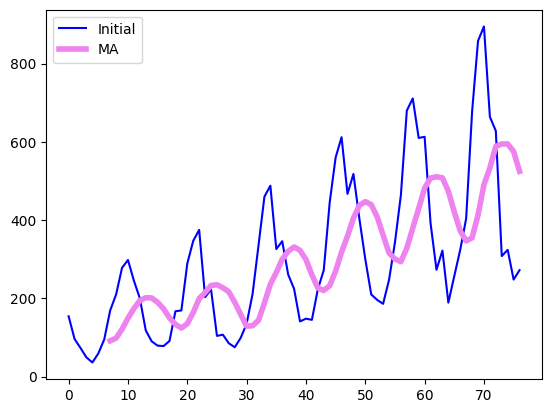

In [14]:
sales.plot(color='blue', label='Initial')
sales.rolling(8).mean().plot(color='violet', linewidth=4, label='MA')
plt.legend()


# SMA сгладила ряд, больше проявив тренд

In [15]:
def exponential_ma(data, const):
    result = [data[0]]
    for n in range(1, len(data)):
        result.append(const * data[n] + (1 - const) * result[n-1])
    return pd.Series(result)

EMA = exponential_ma(sales, 0.7)

Text(0.5, 1.0, 'Monthly sales of company')

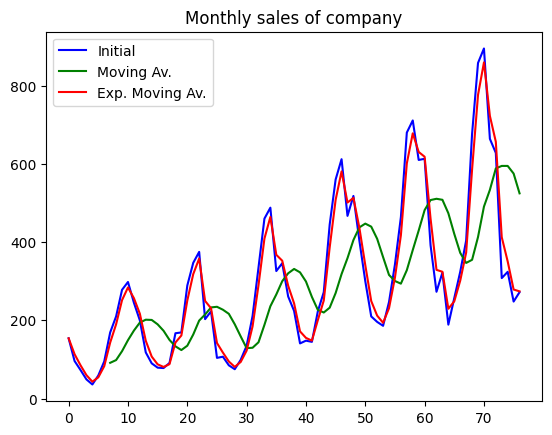

In [16]:
sales.plot(color='blue', label='Initial')
sales.rolling(8).mean().plot(color='green', label='Moving Av.')
EMA.plot(color='red', label='Exp. Moving Av.')
plt.legend()
plt.title('Monthly sales of company')

In [17]:
def double_ema(sales, alpha, beta):
    result = [sales[0]]
    level, trend = sales[0], sales[1] - sales[0]
    for n in range(1, len(sales)):
        last_level, level = level, alpha*sales[n] + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

res = double_ema(sales, 0.2, 0.6)

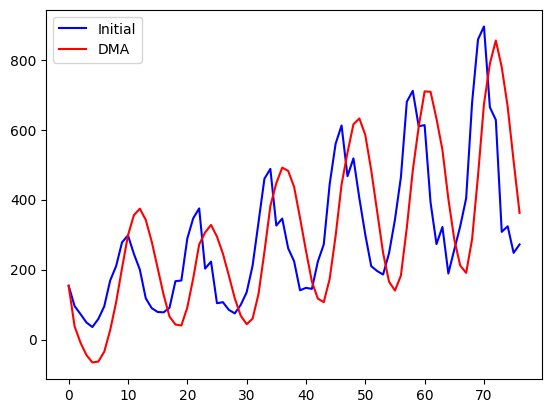

In [18]:
plt.plot(sales, color='blue', label='Initial')
plt.plot(res, color='red', label='DMA')
plt.legend()

In [19]:
def predict(sales, alpha, beta, num_pred):
  preds = [sales[0]]
  level, trend = sales[0], sales[1] - sales[0]
  for n in range(num_pred):
      last_level, level = level, alpha*preds[-1] + (1-alpha)*(level+trend)
      trend = beta*(level-last_level) + (1-beta)*trend
      preds.append(level+trend)

  return preds

pred = predict(sales, 0.7, 0.3, 50)

In [20]:
def double_ema_with_preds(sales, alpha, beta, n_preds):
    result = [sales[0]]
    level, trend = sales[0], sales[1] - sales[0]
    for n in range(1, len(sales)):
        value = sales[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return sales.append(pd.Series(preds), ignore_index=True), pd.Series(result)

<ipython-input-20-e9a778b1b4d0>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return sales.append(pd.Series(preds), ignore_index=True), pd.Series(result)


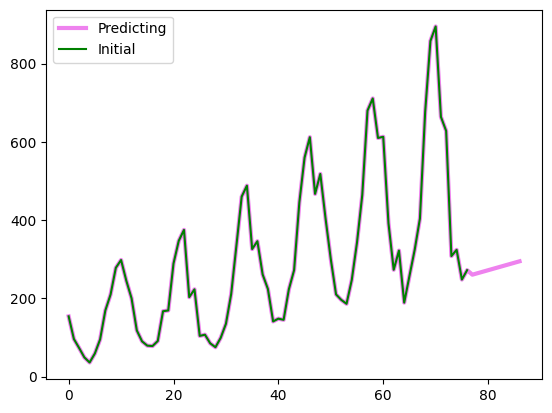

In [26]:
ser, _ = double_ema_with_preds(sales, 0.8, 0.8, 10)
plt.plot(ser, color='violet', linewidth=3, label='Predicting')
plt.plot(sales, color='green', label='Initial')
plt.legend()

In [22]:
def double_ema(sales, alpha, beta):
    result = [sales[0]]
    level, trend = sales[0], sales[1] - sales[0]
    for n in range(1, len(sales)):
        last_level, level = level, alpha*sales[n] + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [23]:
train, test = sales[:60], sales[60:]

In [27]:
def rmse():
    result = double_ema(pd.Series(train), 0.2, 0.6)
    predictions = result[-len(test):]
    error = np.sqrt(mean_squared_error(predictions, test))
    return error

print(f'Ошибка составляет: {round(rmse(), 2)}')

Ошибка составляет: 348.28
